In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [16]:
from fastai.conv_learner import *
from fastai.text import *

from warpctc_pytorch import CTCLoss

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
!ls {PATH}

20_words.csv	 lines	    tmp		       words
ascii		 lines.tgz  word_char_ids.csv  words.csv
line_labels.csv  models     word_labels.csv    words.tgz


In [5]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

# Synthetic Data

### images

In [70]:
os.makedirs(PATH/'synth_words', exist_ok=True)

In [58]:
def create_img(files, fname):
    imgs    = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))

    total_height = sum(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width, total_height), color=(255,255,255))

    y_offset = 0
    for im in imgs:
      new_im.paste(im, (0,y_offset))
      y_offset += im.size[1]

    new_im.save(PATH/'synth_words'/fname)

### labels

In [145]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word'])
df.head()

,filename,word
0,a01-000u-00-00,A
1,a01-000u-00-01,MOVE
2,a01-000u-00-02,to
3,a01-000u-00-03,stop
4,a01-000u-00-04,Mr.


In [125]:
fnames=[]
labels=[]
for i in range(1000):
    res = df.sample(3)
    files = list(map(lambda x: x+'.png', res.filename.values))
    values = res.word.values
    
    fname = '{:03d}'.format(i)+'.png'
    create_img(files, fname)
    fnames.append(fname)
    labels.append(values)
    
synth = pd.DataFrame({'filename': fnames, 'labels': ' '.join(labels)})
synth.head()

,filename,labels,ids
0,000.png,"himself , changes",62 63 67 73 59 66 60 1 12 1 57 62 55 68 61 59 73
1,001.png,be Royal from,56 59 1 46 69 79 55 66 1 60 72 69 67
2,002.png,been . 's,56 59 59 68 1 14 1 7 73
3,003.png,in to .,63 68 1 74 69 1 14
4,004.png,the a says,74 62 59 1 55 1 73 55 79 73


# Prelim

### Numericalize characters

In [177]:
itos = sorted(list(chars))
itos.insert(0, '_pad_')
itos.insert(1, ' ')
itos.insert(2, '_unk_')
len(itos)

81

In [178]:
joined_labels = list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 1, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]) for word in joined_labels])

In [179]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [180]:
synth['ids'] = str_ids
synth.head()

,filename,labels,ids
0,000.png,"himself , changes",62 63 67 73 59 66 60 1 12 1 57 62 55 68 61 59 73
1,001.png,be Royal from,56 59 1 46 69 79 55 66 1 60 72 69 67
2,002.png,been . 's,56 59 59 68 1 14 1 7 73
3,003.png,in to .,63 68 1 74 69 1 14
4,004.png,the a says,74 62 59 1 55 1 73 55 79 73


In [181]:
np.save(TMP_PATH/'synth_word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'synth_word_itos.pkl', 'wb'))

### Save to CSV

In [4]:
# ids = np.load(TMP_PATH/'synth_word_ids.npy')
itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

In [5]:
CSV = PATH/'synth_words.csv'

In [6]:
# synth.to_csv(CSV, columns=['filename', 'ids'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,ids
0,000.png,62 63 67 73 59 66 60 1 12 1 57 62 55 68 61 59 73
1,001.png,56 59 1 46 69 79 55 66 1 60 72 69 67
2,002.png,56 59 59 68 1 14 1 7 73
3,003.png,63 68 1 74 69 1 14
4,004.png,74 62 59 1 55 1 73 55 79 73


In [185]:
len(csv)

1000

### Get val_idxs

In [7]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

150

### Preprocess (rotate, normalize)

In [8]:
f = resnet34
sz = 128
bs = 30

In [9]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'synth_words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [10]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### View image transforms

In [190]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [191]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [192]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


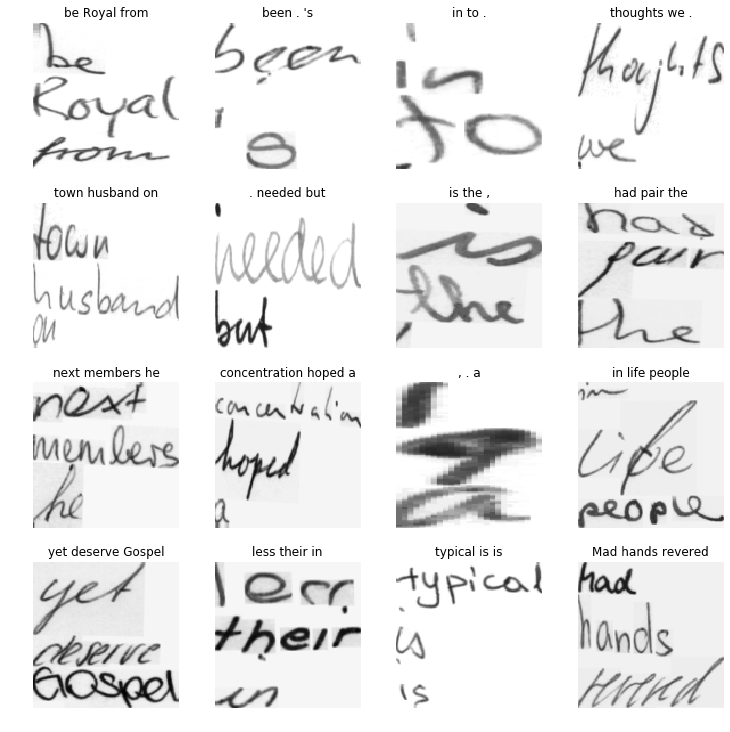

In [193]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Loss fns

In [17]:
ctc_loss = CTCLoss()
# ctc_loss = nn.CTCLoss()  #pytorch master branch (unreleased)

In [ ]:
def custom_loss(input, target):
    bs,sl = target.size()      #=> ([bs, sl])
    _,sl_in,vs = input.size()  #=> ([bs, 4, 16, 80])
    inp = input.permute(1,0,2) #=> ([sl_in, bs, 80])
    
    inp_lens = torch.full((bs,), sl_in, dtype=torch.int32)
    
    ##NOTE: inp => gpu, everything else on cpu!!
    
    # need to remove 0s from labels (same as ctc blank character)
    targ = []
    targ_lens = []
    for i in range(bs):
        t = target[i,:]
        # remove 0 padding from targets
        t = t[t.nonzero().squeeze(1)]
        targ.append(t)
        targ_lens.append(len(t))

    targ = torch.cat(targ).type(torch.int32).cpu()
    targ_lens = torch.tensor(targ_lens, dtype=torch.int32)
    
#     targ = target.reshape(bs*sl).type(torch.int32)
#     targ_lens = torch.full((bs,), sl, device=device, dtype=torch.int32)
    
    return ctc_loss(inp, targ, inp_lens, targ_lens)
    
    
    # inputs: Tensor of (seqLength x batch x vocab_size) containing output activations from network (before softmax)
    # targets: 1 dimensional Tensor containing all the targets of the batch in one large sequence
    # input_lens: Tensor of size (batch) containing size of each output sequence from the network
    # target_lens: Tensor of (batch) containing label length of each example

# Hybrid Arch

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.2, p=(2,2)):
        super().__init__()
        self.p = p
        
        self.drop = nn.Dropout(drop)
        self.conv = nn.Conv2d(ni*p[0]*p[1], nh, 3, padding=1)  #maintain size
        self.bn   = nn.BatchNorm2d(nh)
    
    def tile(self, x):
        bs, nf, h, w = x.size()   # Note: different order than ReNet tile!!!
        p_height = self.p[0]
        p_width  = self.p[1]

        assert h % p_height == 0
        assert w % p_width  == 0

        new_height = int(h / p_height)
        new_width  = int(w / p_width)

        x = x.view(bs, nf, new_height, p_height, new_width, p_width)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(bs, nf * p_height * p_width, new_height, new_width)
        return x

    def forward(self, x):
        x = self.tile(x)
        x = self.bn(self.conv(self.drop(x)))
        x = F.leaky_relu(x)
        return x

In [12]:
class ReNetBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.4, p=(2,1)):
        super(ReNetBlock, self).__init__()
        
        self.p_height = p[0]
        self.p_width = p[1]

        self.drop = nn.Dropout(drop)
        self.vrnn = nn.GRU(ni*self.p_height*self.p_width, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
        self.hrnn = nn.GRU(2*nh, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
    
    def tile(self, x):
        bs, h, w, nf = x.size()

        assert h % self.p_height == 0
        assert w % self.p_width  == 0

        new_height = int(h / self.p_height)
        new_width  = int(w / self.p_width)

        x = x.view(bs, new_height, self.p_height, new_width, self.p_width, nf)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(bs, new_height, new_width, self.p_height * self.p_width * nf)
        return x
    
    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']
        bs, h, w, nf = x.size()

        x = x.view(bs*h, w, nf)
        if hor_or_ver == 'hor':
            x, _ = self.hrnn(x)
        else:
            x, _ = self.vrnn(x)
        x = x.contiguous()
        x = x.view(bs, h, w, -1)
        return x

    def forward(self, inp):
        x = self.tile(inp)                 #bs, h, w, nf
        x = self.drop(x)
        
        x = self.rnn_forward(x, 'ver')
        x = x.permute(0, 2, 1, 3)          #bs, w, h, nf
        x = x.contiguous()
        
        x = self.rnn_forward(x, 'hor')
        x = x.permute(0, 2, 1, 3)          #bs, h, w, nf
        x = x.contiguous()
        return x

In [ ]:
class Hybrid(nn.Module):
    def __init__(self, nh, vs):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
           
        self.block1 = ReNetBlock(16, nh, p=(4,2))
        self.block2 = ReNetBlock(32, nh, p=(2,2))
        self.block3 = ReNetBlock(64, nh, p=(2,2))
        
        self.conv1 = ConvBlock(nh*2, 32, p=(2,1))
        self.conv2 = ConvBlock(nh*2, 64, p=(2,1))
        self.conv3 = ConvBlock(nh*2, 128, p=(2,1))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(128, vs)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        
        x = self.conv0(inp)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2(x)

        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block3(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3(x)

        x = x.permute(0, 2, 3, 1)
        x = self.drop(x)
        x = self.out(x)      #([30, 1, 16, 80])
        
        return x.squeeze(1)

In [ ]:
net = Hybrid(100, len(itos))
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.crit = custom_loss
learn.clip = 10.
learn.metrics = [char_error_rate]

# Custom Arch

In [12]:
class ReNetBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.4, p=(2,1)):
        super(ReNetBlock, self).__init__()
        
        self.p_height = p[0]
        self.p_width = p[1]

        self.drop = nn.Dropout(drop)
        self.vrnn = nn.GRU(ni*self.p_height*self.p_width, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
        self.hrnn = nn.GRU(2*nh, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
    
    def tile(self, x):
        bs, h, w, nf = x.size()

        assert h % self.p_height == 0
        assert w % self.p_width  == 0

        new_height = int(h / self.p_height)
        new_width  = int(w / self.p_width)

        x = x.view(bs, new_height, self.p_height, new_width, self.p_width, nf)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(bs, new_height, new_width, self.p_height * self.p_width * nf)
        return x
    
    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']
        bs, h, w, nf = x.size()

        x = x.view(bs*h, w, nf)
        if hor_or_ver == 'hor':
            x, h = self.hrnn(x)
        else:
            x, h = self.vrnn(x)
        x = x.contiguous()
        x = x.view(bs, h, w, -1)
        return x, h

    def forward(self, inp):
        x = self.tile(inp)                 #bs, h, w, nf
        x = self.drop(x)
        
        x, _ = self.rnn_forward(x, 'ver')
        x = x.permute(0, 2, 1, 3)          #bs, w, h, nf
        x = x.contiguous()
        
        x, _ = self.rnn_forward(x, 'hor')
        x = x.permute(0, 2, 1, 3)          #bs, h, w, nf
        x = x.contiguous()
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, nh, vs):
        super().__init__()
        
        # 16x16x256
        self.conv0 = nn.Conv2d(256, 16, 1)   # 1x1 conv to reduce num filters
           
        self.block1 = ReNetBlock(16, nh, p=(1,1))
        self.block2 = ReNetBlock(32, nh, p=(1,1))
        self.block3 = ReNetBlock(64, nh, p=(1,1))
        
        self.conv1 = ConvBlock(nh*2, 32, p=(1,1))
        self.conv2 = ConvBlock(nh*2, 64, p=(2,1))
        self.conv3 = ConvBlock(nh*2, 128, p=(2,1))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(128, vs)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        
        x = self.conv0(inp)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2(x)

        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block3(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3(x)

        x = x.permute(0, 2, 3, 1)
        x = self.drop(x)
        x = self.out(x)      #([bs, 4, 16, vs])
        
        return x

In [ ]:
decoder = Decoder(100, len(itos))
net = ConvnetBuilder(f, 0, 0, 0, xtra_cut=1, custom_head=decoder)
opt_fn = partial(optim.Adam), betas=(0.7, 0.99)
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.crit = custom_loss